In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.autograd.functional import hessian, jacobian

In [2]:
dtype = torch.float
#device = torch.device("cuda:0")
device = torch.device("cpu")

# Number of points to train on
num_points = 100

# normalized time domain for ODE
t = torch.linspace(0, 2, num_points, device=device, dtype=dtype, requires_grad=True).reshape(-1,1)

# Make a random symetric + real matrix
Q = torch.randn(6,6, device=device, dtype=dtype, requires_grad=False)
A = torch.transpose(Q, 0, 1) + Q 
A.requires_grad = True

# Initial guess for the eigenvalue
v0 = torch.randn(A.size(0), device=device, dtype=dtype, requires_grad=False).reshape(-1,1)
#eigval, eigvec = np.linalg.eigh(A.detach().numpy())
#v0 = torch.from_numpy(eigvec[:, -1]).reshape(-1,1)


# Trial solution to ODE
def f_trial(t, N):
    return v0 * torch.exp(-t) + (1 - torch.exp(-t)) * N

# Shape of network
input_dim = 1
hidden_neurons = 50
output_dim = v0.size(0)

# Create random Tensors for weights.
w1 = torch.randn(input_dim, hidden_neurons, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(hidden_neurons, output_dim, device=device, dtype=dtype, requires_grad=True)

In [3]:
print(v0)

tensor([[ 0.8555],
        [ 0.5146],
        [-0.6950],
        [-1.0461],
        [ 1.1560],
        [-1.8775]])


In [4]:
#v0.transpose(0,1).mm(A).mm(v0)
v0_T = v0.transpose(0,1)
(- v0 + (v0_T.mm(v0) * A  + (1 - v0_T.mm(A).mm(v0)) * torch.eye(v0.size(0))).mm(v0))

tensor([[-17.8462],
        [-15.5719],
        [ -9.0246],
        [-68.2533],
        [-34.1037],
        [  7.9744]], grad_fn=<AddBackward0>)

propose a trial solution to the ODE in the form
$$ 
    f_t(t, P) = v_0 \, e^{-t} + (1-e^{-t}) N(t,P)
$$
Where $N$ denotes the Neural Network, and $P$ its free parameters.

In [5]:
def costfunction(t, N, A, trial_func):
    loss = 0
    
    for i in range(t.size(0)):
        # Compute trial eigenvector & transpose
        v = trial_func(t[i], N[i])
        v_T = v.transpose(0,1)
       
        # Time derivative of trial function
        dfdt, dfdN = jacobian(trial_func, (t[i], N[i]), create_graph=True)  
        
        # right hand side of ODE
        RHS = (- v + (v_T.mm(v) * A  + (1 - v_T.mm(A).mm(v)) * torch.eye(v.size(0))).mm(v))
        
           # (-x_t + (x_t.T @ x_t * A + (1 - x_t.T @ A @ x_t) * np.identity(np.size(x_t,0))) @ x_t)
        
        # Increment the loss function
        loss = loss + (dfdt - RHS).pow(2).mean()
    
    return loss / t.size(0)

0: loss =  tensor(163.7056, grad_fn=<DivBackward0>)
10: loss =  tensor(163.6874, grad_fn=<DivBackward0>)
20: loss =  tensor(163.6692, grad_fn=<DivBackward0>)
30: loss =  tensor(163.6511, grad_fn=<DivBackward0>)
40: loss =  tensor(163.6331, grad_fn=<DivBackward0>)
50: loss =  tensor(163.6151, grad_fn=<DivBackward0>)
60: loss =  tensor(163.5971, grad_fn=<DivBackward0>)
70: loss =  tensor(163.5792, grad_fn=<DivBackward0>)
80: loss =  tensor(163.5613, grad_fn=<DivBackward0>)
90: loss =  tensor(163.5434, grad_fn=<DivBackward0>)


Text(0, 0.5, 'Loss')

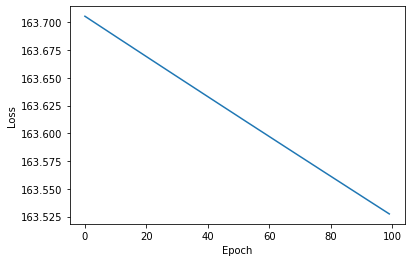

In [6]:
EPOCHS = 100

loss_arr = np.empty(EPOCHS, dtype=np.float)

learning_rate = 0.0000002
for epoch in range(EPOCHS):
    N_output = F.relu(t.mm(w1)).mm(w2)
        
    # Compute and print loss    
    loss = costfunction(t, N_output.reshape(-1,1), A, f_trial)
    
    loss_arr[epoch] = loss.detach().numpy()
    
    if epoch % 10 == 0:
        print(f"{epoch}: loss = ",loss)
    
    # Use autograd to compute the backward pass.
    loss.backward()

    # Update weights using gradient descent
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad
    
        # Manually zero the gradients after updating weights
        w1.grad.zero_()
        w2.grad.zero_()
        
plt.plot(loss_arr)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [7]:
v_pred = f_trial(t[-1,:], N_output[-1,:].reshape(-1,1))

print("before norm: \n",v_pred)
v_pred = v_pred/v_pred.norm()
print("after norm: \n", v_pred)

eigval, eigvec = np.linalg.eigh(A.detach().numpy())
print(eigval)
print(eigvec)

print(eigvec[:,-1])

before norm: 
 tensor([[-2.0074],
        [-5.5732],
        [-4.2648],
        [-4.7267],
        [ 6.2811],
        [ 4.8696]], grad_fn=<AddBackward0>)
after norm: 
 tensor([[-0.1704],
        [-0.4731],
        [-0.3620],
        [-0.4012],
        [ 0.5332],
        [ 0.4134]], grad_fn=<DivBackward0>)
[-6.5943747 -2.0519478  2.016969   3.6007907  6.2429876  8.069728 ]
[[ 0.75297636  0.41292137  0.07771002 -0.03386141 -0.04484463 -0.5033151 ]
 [ 0.16694582 -0.35794085  0.15603879  0.06602781 -0.9011984   0.05604583]
 [ 0.06996942  0.5340041   0.53327996 -0.10761691 -0.07494377  0.6390293 ]
 [ 0.45703185 -0.3873107   0.12924461  0.64721227  0.32777265  0.31319252]
 [ 0.40920407 -0.07979841 -0.63630867 -0.4386045  -0.00505643  0.47843087]
 [-0.154706    0.50974166 -0.51345176  0.60963494 -0.26972833  0.09049138]]
[-0.5033151   0.05604583  0.6390293   0.31319252  0.47843087  0.09049138]


In [8]:
eigval, eigvec = np.linalg.eigh(A.detach().numpy())
print(eigval)
print(eigvec)

[-6.5943747 -2.0519478  2.016969   3.6007907  6.2429876  8.069728 ]
[[ 0.75297636  0.41292137  0.07771002 -0.03386141 -0.04484463 -0.5033151 ]
 [ 0.16694582 -0.35794085  0.15603879  0.06602781 -0.9011984   0.05604583]
 [ 0.06996942  0.5340041   0.53327996 -0.10761691 -0.07494377  0.6390293 ]
 [ 0.45703185 -0.3873107   0.12924461  0.64721227  0.32777265  0.31319252]
 [ 0.40920407 -0.07979841 -0.63630867 -0.4386045  -0.00505643  0.47843087]
 [-0.154706    0.50974166 -0.51345176  0.60963494 -0.26972833  0.09049138]]


[[ 0.31372872]
 [ 0.18873698]
 [-0.25487995]
 [-0.38365737]
 [ 0.4239288 ]
 [-0.68853486]]
[[2.176974]]
[[ 0.5033151 ]
 [-0.05604583]
 [-0.6390293 ]
 [-0.31319251]
 [-0.47843086]
 [-0.09049138]]


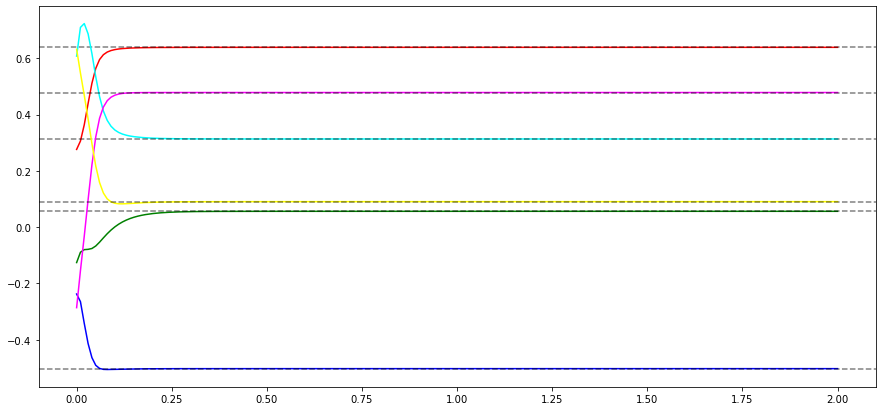

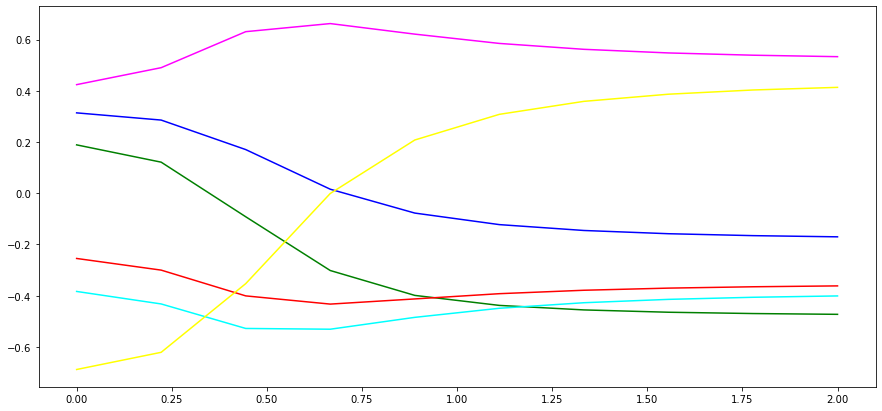

In [29]:
v_pred_np = np.zeros([t.size(0), 6])
for i in range(t.size(0)):
    ft = f_trial(t[i,:], N_output[i,:].reshape(-1,1)).detach().numpy().reshape(6)
    v_pred_np[i] = ft / np.sqrt(np.dot(ft, ft))

#Forward Euler for Yi et al diff.eq


x_t = v0.detach().numpy()
A_t = A.detach().numpy()
dt = 0.01
N = 200

time = np.linspace(0, dt * N, N)

print(x_t/np.sqrt(x_t.T @ x_t)) # normalized eigenvector
print(x_t.T @ A_t @ x_t / (x_t.T @ x_t)) # eigenvalue

x_euler = np.zeros([N, 6])


for i in range(N):
    x_t = x_t + (-x_t + (x_t.T @ x_t * A_t + (1 - x_t.T @ A_t @ x_t) * np.identity(6)) @ x_t)*dt
    x_euler[i, :] = x_t.reshape(6)
    x_euler[i, :] /= np.sqrt(np.dot(x_euler[i, :], x_euler[i, :]))
    

    
print(x_t/np.sqrt(x_t.T @ x_t)) # normalized eigenvector
#print(x_t.T @ A_t @ x_t / (x_t.T @ x_t)) # eigenvalue

#print(eigvec[:,-1])

colors = ["blue", "green", "red", "cyan", "magenta", "yellow"]

plt.figure(figsize=(15, 7))
for d in range(6):
    plt.plot(time, -x_euler[:, d], color=colors[d])
    plt.axhline(eigvec[d, -1], alpha=0.5, color="black", ls="--")

plt.figure(figsize=(15, 7))
for d in range(6):
    plt.plot(t.detach().numpy(), v_pred_np[:, d], color=colors[d])
